## Time-Series Decomposition (Chosen approach)

Extract the seasonal patterns from the time-series

In [1]:
from data_exploitation.exports_analytics.data.scripts import time_series_generator
from data_exploitation.exports_analytics.exploratory_data_analysis.scripts import time_granularities_analysis, time_granularities_generator
from database_settings import postgres_utilities
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import pearsonr
import wandb
from sklearn.metrics import mean_squared_error, mean_absolute_error


from data_exploitation.exports_analytics.data_modeling.models import linear_regression, gam, prophet_1, prophet_2, prophet_3, arima, gradient_boosting


Importing plotly failed. Interactive plots will not work.


### Get available headings

In [2]:
# Get available headings from peru_exports_sandbox
engine = postgres_utilities.engine()
available_headings = postgres_utilities.run_query_file(engine,
                                                       './../data/queries/read_available_headings.sql')
available_headings = pd.DataFrame(available_headings)
available_headings

Connected to Formatted Zone successfully!


,heading,description
0,0712909000,Otras hortalizas y mezclas de hortalizas corta...
1,0805291000,Tangelo (Citrus reticulata x Citrus paradisis)...
2,0810400000,"Arándanos rojos, mirtilos y demas frutos del g..."
3,0713359000,"Frijoles (fréjoles, porotos, alubias, judías) ..."
4,0805502100,"Limón (limón sutil, limón común, limón criollo..."
5,0810901000,"Granadilla, maracuya (parchita) y demas frutas..."
6,0702000000,Tomates frescos o refrigerados
7,0709999000,Otras hortalizas frescas o refrigeradas
8,0801220000,Nueces del Brasil sin cáscara
9,0710400000,"Maiz dulce incluso cocidos, congelados"


### Build a time-series

In [75]:
# Choose a heading
chosen_heading = '0709200000'
# Choose the observed measure (usd_kg or net_weight)
observations = 'usd_kg'

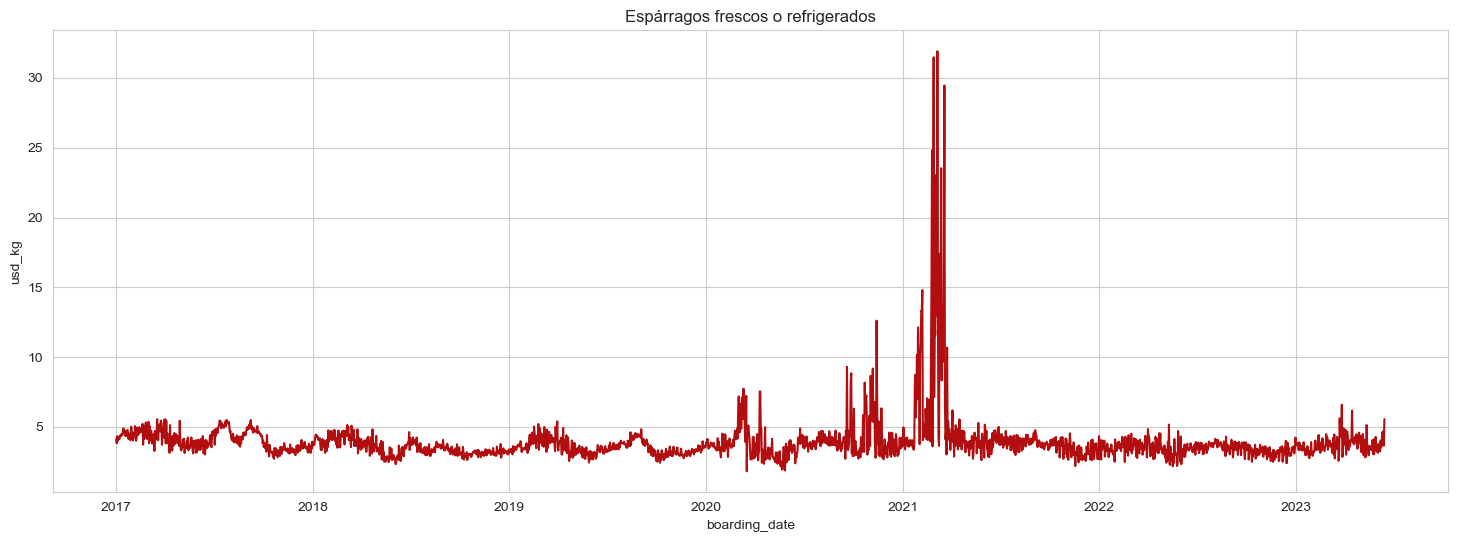

In [76]:
# Get a time-series
ts = time_series_generator.generate(chosen_heading, observations)
ts.plot()

In [77]:
# Add the time granularities
time_granularities, priority = time_granularities_generator.generate(ts.start_date, ts.end_date)
data = pd.concat([ts.data, time_granularities], axis=1)
data

,usd_kg,year,semester_in_year,quarter_in_year,month_in_year,month_in_semester,month_in_quarter,quarter_in_semester,day_in_year,day_in_semester,day_in_quarter,day_in_month,day_in_week,week_in_year,week_in_semester,week_in_quarter,week_in_month
2017-01-01,4.137,2017,1,1,1,1,1,1,1,1,1,1,7,52,26,13,5
2017-01-02,3.836,2017,1,1,1,1,1,1,2,2,2,2,1,1,1,1,1
2017-01-03,4.338,2017,1,1,1,1,1,1,3,3,3,3,2,1,1,1,1
2017-01-04,4.012,2017,1,1,1,1,1,1,4,4,4,4,3,1,1,1,1
2017-01-05,4.135,2017,1,1,1,1,1,1,5,5,5,5,4,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-10,4.616,2023,1,2,6,6,3,2,161,161,71,10,6,23,23,10,2
2023-06-11,3.900,2023,1,2,6,6,3,2,162,162,72,11,7,23,23,10,2
2023-06-12,4.701,2023,1,2,6,6,3,2,163,163,73,12,1,24,24,11,3
2023-06-13,3.654,2023,1,2,6,6,3,2,164,164,74,13,2,24,24,11,3


### Get a list of the seasonal patterns to extract

In [78]:
# Get a list of seasonal patterns in order of extraction
def get_existing_granularities(granularities, data, observations):

    selected_granularities = []
    for g in granularities:
        print('Analyzing {}...'.format(g))
        seasonality_analysis = time_granularities_analysis.analysis(cyclic_granularity=g,
                                        observations=observations,
                                        data=data)
        # seasonality_analysis.plot()
        # print(seasonality_analysis.summary())
        if seasonality_analysis.is_seasonal():
            selected_granularities.append(g)
    selected_granularities = [x for x in priority if x in selected_granularities]
    selected_granularities

    return selected_granularities

### Extraction approaches

In [79]:
# Approach 1: Get the seasonal patterns, exracting each directly from the original series

def seasons_extraction(data_df, observations_column, selected_granularities):

    # Initialize the residuals
    time_series = data_df[observations_column].values
    # Initialize the seasonal patterns
    seasonal_patterns = {}

    # Get the pattern for every granularity
    for granularity in selected_granularities:

        # Get the label of every observation
        labels = data_df[granularity].values
        # Generate the pattern
        pattern = []
        for label in labels:
            value = np.mean(time_series[np.where(labels == label)])
            pattern.append(value)
        seasonal_patterns[granularity] = pattern

    return seasonal_patterns

### Extraction process

In [80]:
# Define the granularities to analyze
granularities = ['semester_in_year',
                 'quarter_in_year',
                 'month_in_year',
                 'month_in_semester',
                 'month_in_quarter',
                 'quarter_in_semester',
                 'day_in_month',
                 'day_in_week',
                 'week_in_year',
                 'week_in_semester',
                 'week_in_quarter',
                 'week_in_month']

# Get the granularities to extract
selected_granularities = get_existing_granularities(granularities, data, observations)
print("The time-series has {} seasonalities detected".format(len(selected_granularities)))
# Get the seasonal patterns
seasonal_patterns = seasons_extraction(data_df=data,
                                       observations_column=observations,selected_granularities=selected_granularities)


Analyzing semester_in_year...
Analyzing quarter_in_year...
Analyzing month_in_year...
Analyzing month_in_semester...
Analyzing month_in_quarter...
Analyzing quarter_in_semester...
Analyzing day_in_month...
Analyzing day_in_week...
Analyzing week_in_year...
Analyzing week_in_semester...
Analyzing week_in_quarter...
Analyzing week_in_month...
The time-series has 6 seasonalities detected


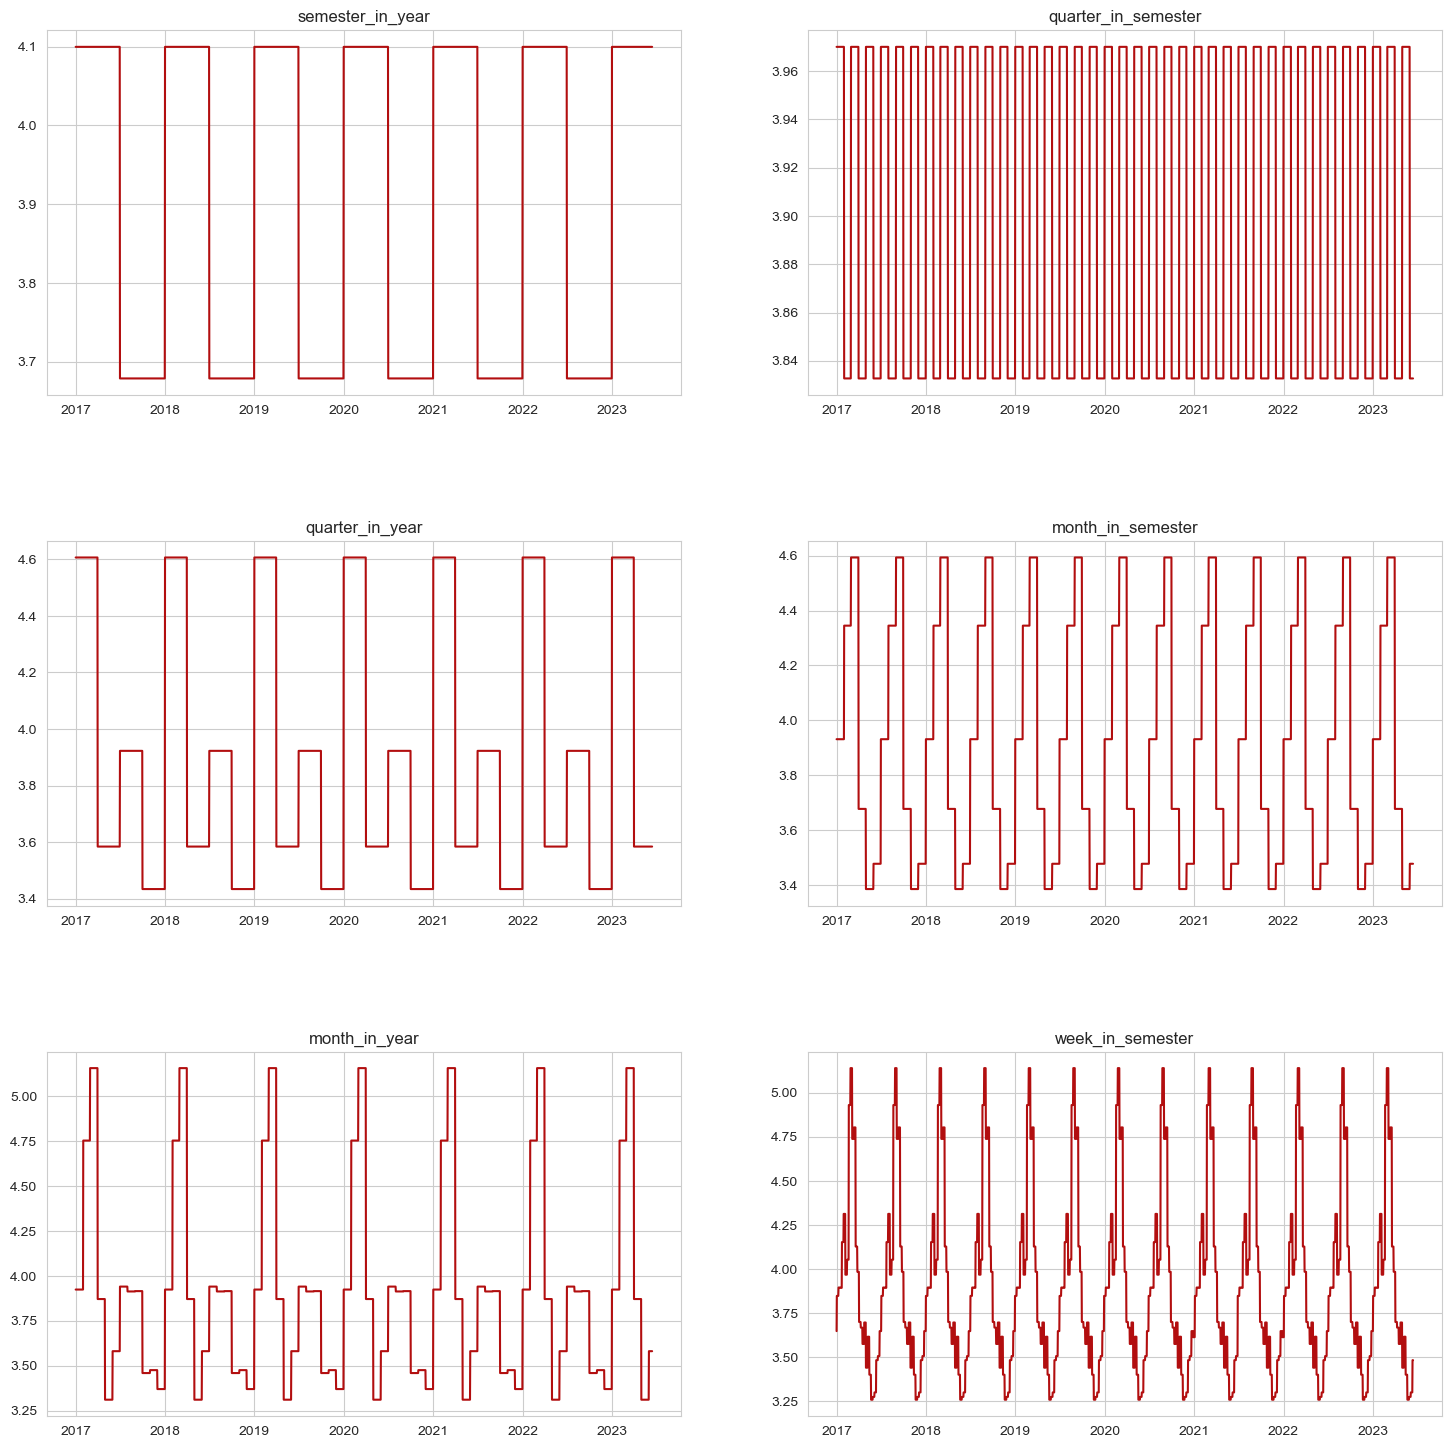

In [81]:
# Plot seasonal patterns

num_patterns = len(seasonal_patterns)
num_rows = (num_patterns + 1) // 2  # Calculate the number of rows needed for subplots

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(18, 6 * num_rows))
plt.subplots_adjust(hspace=0.4)  # Adjust the vertical spacing between subplots

# Iterate over seasonal patterns and plot them in the subplots
for i, (key, value) in enumerate(seasonal_patterns.items()):
    row = i // 2  # Row index of the subplot
    col = i % 2   # Column index of the subplot

    ax = axes[row, col]  # Get the current subplot
    sns.lineplot(x=data.index, y=value, ax=ax, color="#B20E0F")
    ax.set_title(key)

# Remove empty subplots if there are more seasonal patterns than available subplots
if num_patterns % 2 != 0:
    fig.delaxes(axes[-1, -1])

plt.show()


### Extract the trend

In [82]:
import math
# Initialize the parameters
percentage = 0.00
# Define the tresholds
statistic_th = 0.05
alpha = 0.05

correlation_exists = True

while(correlation_exists ## while they are correlated
      and
      not(math.isclose(percentage, 1)) # while the fraction for the lowess isn't 100%
):
    # Increase the percentage
    percentage = round(percentage + 0.01, 2)

    # Get the trend
    trend = sm.nonparametric.lowess(data[observations], data.index, frac=percentage)[:, 1]
    # Initialize the statistics summary
    pearson_correlations ={}
    # Make the comparisons
    for granularity, seasonal_pattern in seasonal_patterns.items():

        # Compute Pearson correlation coefficient and p-value
        analysis = pearsonr(seasonal_pattern, trend)

        pearson_correlations[granularity] = {'statistic':analysis.statistic, 'pvalue':analysis.pvalue}

    # Get the max correlation
    granularity, metrics = max(pearson_correlations.items(), key=lambda x: abs(x[1]['statistic']))
    statistic = metrics['statistic']
    # print(granularity)
    # print(statistic)

    # If the max correlation is smaller than the threshold, assess its significance
    if abs(statistic) < statistic_th:
        pvalue = pearson_correlations[granularity]['pvalue']/2
        # print('pvalue: {}'.format(pvalue))
        # If the pvalue is smaller than the threshold, it's significant
        if pvalue < alpha:
            correlation_exists = False

pearson_correlations = pd.DataFrame.from_dict(pearson_correlations, orient='index')
print('Fraction chosen: {}'.format(percentage))

pearson_correlations

Fraction chosen: 1.0


,statistic,pvalue
semester_in_year,0.069573,0.000727
quarter_in_semester,0.018112,0.379548
quarter_in_year,0.078928,0.000126
month_in_semester,0.042244,0.040336
month_in_year,0.059548,0.003835
week_in_semester,0.040633,0.048605


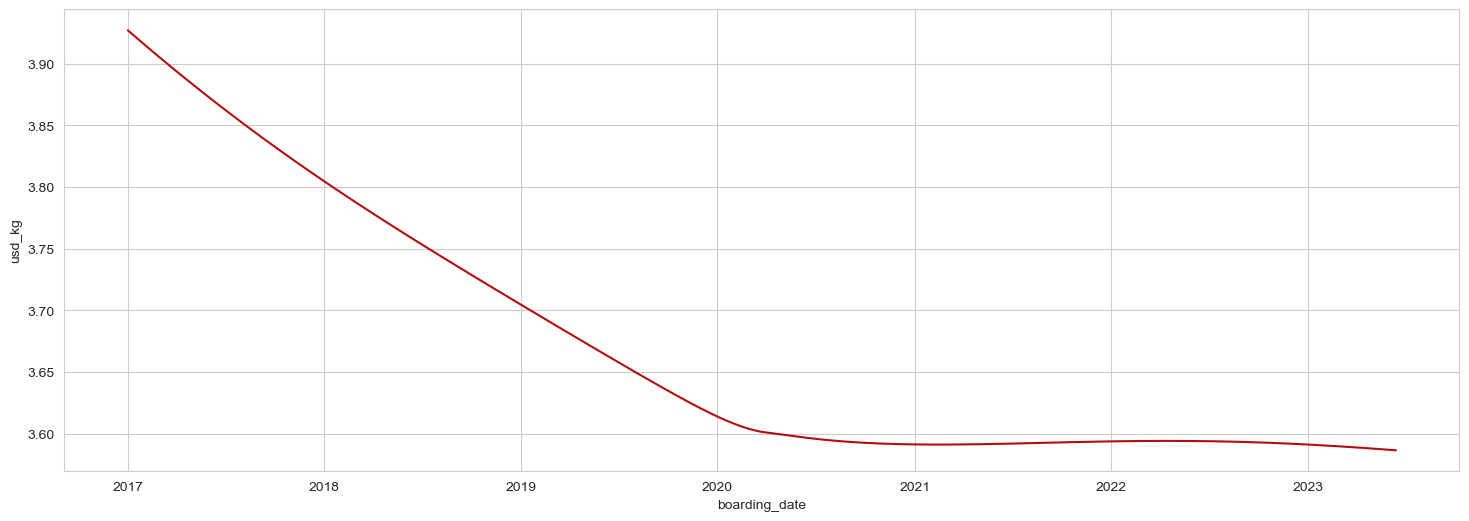

In [83]:
# Plot trend
plt.figure(figsize=(18, 6))
sns.lineplot(x = data.index, y=trend, color="#B20E0F")
plt.ylabel('usd_kg')  # Add y-axis label
plt.xlabel('boarding_date')  # Add x-axis label
plt.show()

### Test a model


In [84]:
# Define the training and test set
X = np.array([trend] + list(seasonal_patterns.values())).T
y = data[observations].values

train_frac = 0.8 # fraction of the data to train with
train_size = int(train_frac * len(X))

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Choose the number of steps to predict
steps = 30

### Multi-step Models

#### Multi-step Multivariate Linear Regression

In [85]:
model = linear_regression.model(explanatory_variables = X,
                                target_variable = y,
                                target_name = observations,
                                timepoints = data.index,
                                training_fraction = 0.8,
                                steps = 30)

{'rmse': 0.8315647053346953, 'mae': 0.6287513491889435}


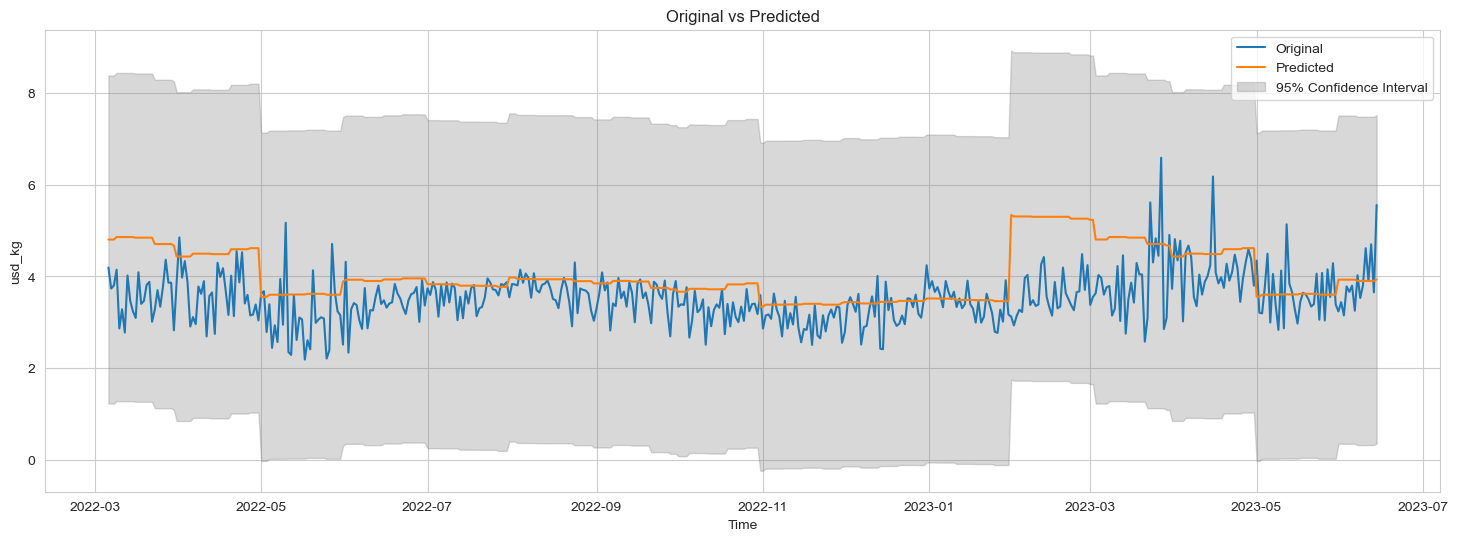

In [86]:
print(model.test())
model.plot_test()

In [87]:
# import statsmodels.api as sm
# from sklearn.metrics import mean_squared_error, mean_absolute_error
#
# # Create a LinearRegression model
# model = sm.OLS(y_train[steps:], X_train[:-steps])
# # Fit the model to the training data
# model = model.fit()
#
# # Make predictions with the test data
# y_pred = model.predict(X_test[:-steps])
# print(X_train[:-steps].shape)
# print(X_test[:-steps].shape)
# conf_in = model.get_prediction((X_test[:-steps])).summary_frame(alpha=0.05)
#
# # Calculate error metrics
# mrse = np.sqrt(mean_squared_error(y_test[steps:], y_pred))
# mae = mean_absolute_error(y_test[steps:], y_pred)
#
# print("Mean Rooth Squared Error:", mrse)
# print("Mean Absolute Error:", mae)
#
# # Plot original vs predicted
# plt.figure(figsize=(18, 6))
# sns.lineplot(x = data.index[-len(y_test[steps:]):], y=y_test[steps:], label='Original')
# sns.lineplot(x = data.index[-len(y_test[steps:]):], y=y_pred, label='Predicted')
# plt.fill_between(data.index[-len(y_test[steps:]) :],
#                  conf_in["obs_ci_lower"],
#                  conf_in["obs_ci_upper"],
#                  color='gray',
#                  alpha=0.3,
#                  label='Confidence Interval')
# plt.xlabel('Time')
# plt.ylabel(observations)
# plt.title('Original vs Predicted')
# plt.legend()
#
# #----------------------------------------------------------
# # Experiment tracking
# #----------------------------------------------------------
# wandb.init(
#     mode = 'disabled',
#     # set the wandb project where this run will be logged
#     project="thesis_time_series_forecasting",
#
#     # track information and parameters
#     config={
#     "model": 'Linear Regression',
#     "observations": observations,
#     "steps" : steps,
#     "train_fraction": train_frac,
#     "train_len" : len(X_train),
#     "test_len" : len(X_test),
#     }
# )
#
# # Log metrics to wandb
# wandb.log({"mrse": mrse, "mae": mae, 'chart': wandb.Image(plt)})
# # Finish wandb
# wandb.finish()
# #----------------------------------------------------------
#
# plt.show()
#

#### Multi-step Generalized Additive Models (GAM)


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


{'mrse': 1.064104740475071, 'mae': 0.7783484415584917}


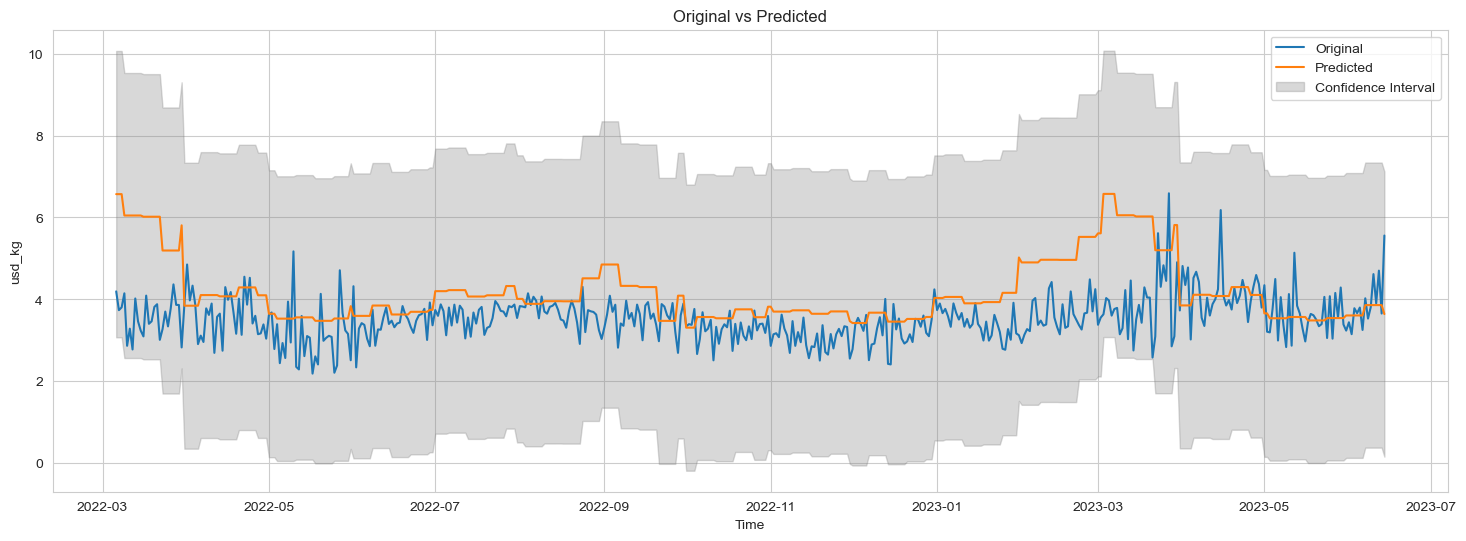

In [88]:
model = gam.model(explanatory_variables=X,
                                target_variable=y,
                                target_name=observations,
                                timepoints=data.index,
                                training_fraction=0.8,
                                steps=30)
print(model.test())
model.plot_test()

In [89]:
# from pygam import LinearGAM, s, f, l, terms
#
# # #Define the lambdas that penalize the willingness
# # trend_lam = 0
# # seasonal_lam = 0
# # lams = [np.array([trend_lam])] + [np.copy(seasonal_lam) for _ in range(len(seasonal_patterns))]
#
# my_terms = terms.TermList(l(0))
# for i in range(len(seasonal_patterns)):
#     my_terms += s(i+1, basis='cp')
#
# # Create the GAM model
# model = LinearGAM(my_terms).gridsearch(X_train,y_train)
#
# # Make predictions with the test data
# y_pred = model.predict(X_test[:-steps])
# conf_in = model.prediction_intervals(X_test[:-steps], width=0.95)
#
#
# # Calculate error metrics
# rmse = np.sqrt(mean_squared_error(y_test[steps:], y_pred))
# mae = mean_absolute_error(y_test[steps:], y_pred)
#
# print("Root Mean Squared Error:", rmse)
# print("Mean Absolute Error:", mae)
#
#
# # Plot original vs predicted
# plt.figure(figsize=(18, 6))
# sns.lineplot(x = data.index[-len(y_test[steps:]):], y=y_test[steps:], label='Original')
# sns.lineplot(x = data.index[-len(y_test[steps:]):], y=y_pred, label='Predicted')
# plt.fill_between(data.index[-len(y_test[steps:]) :],
#                  conf_in[:,0],
#                  conf_in[:,1],
#                  color='gray',
#                  alpha=0.3,
#                  label='Confidence Interval')
# plt.xlabel('Time')
# plt.ylabel(observations)
# plt.title('Original vs Predicted')
# plt.legend()
#
# #----------------------------------------------------------
# # Experiment tracking
# #----------------------------------------------------------
# wandb.init(
#     mode = 'disabled',
#     # set the wandb project where this run will be logged
#     project="thesis_time_series_forecasting",
#
#     # track information and parameters
#     config={
#     "model": 'GAM',
#     "observations": observations,
#     "steps" : steps,
#     "train_fraction": train_frac,
#     "train_len" : len(X_train),
#     "test_len" : len(X_test),
#     "terms" : str(my_terms)
#     }
# )
#
# # Log metrics to wandb
# plt.savefig('chart.png', format='png')
# wandb.log({"rmse": rmse, "mae": mae, 'chart': wandb.Image(plt)})
# # Finish wandb
# wandb.finish()
# #----------------------------------------------------------
#
# plt.show()

In [90]:
# for i, term in enumerate(model.terms):
#     if term.isintercept:
#         continue
#
#     XX = model.generate_X_grid(term=i)
#     pdep, confi = model.partial_dependence(term=i, X=XX, width=0.95)
#
#     plt.figure()
#     plt.plot(XX[:, term.feature], pdep)
#     plt.plot(XX[:, term.feature], confi, c='r', ls='--')
#     plt.title(repr(term))
#     plt.show()

In [91]:
# # See the original and transformed predictors
#
# # Trend
# transformed_trend = model.partial_dependence(term=0, X=X)
# plt.figure(figsize=(18, 6))
# sns.lineplot(x=data.index, y=trend, label='Original')
# sns.lineplot(x=data.index, y=transformed_trend, label='Transformed')
# plt.xlabel('Time')
# plt.ylabel(observations)
# plt.title('Original vs Transformed Trend')
# plt.legend()
# plt.show()
#
# # Seasonal components
#
# for index, (granularity, pattern) in enumerate(seasonal_patterns.items()):
#
#     transformed_pattern = model.partial_dependence(term=index+1, X=X)
#     plt.figure(figsize=(18, 6))
#     sns.lineplot(x=data.index, y=pattern, label='Original')
#     sns.lineplot(x=data.index, y=transformed_pattern, label='Transformed')
#     plt.xlabel('Time')
#     plt.ylabel(observations)
#     plt.title('Original vs Transformed {}'.format(granularity))
#     plt.legend()
#     plt.show()

#### Prophet without regressors

13:31:14 - cmdstanpy - INFO - Chain [1] start processing
13:31:17 - cmdstanpy - INFO - Chain [1] done processing


{'rmse': 3.517917768579909, 'mae': 3.1845183953403158}


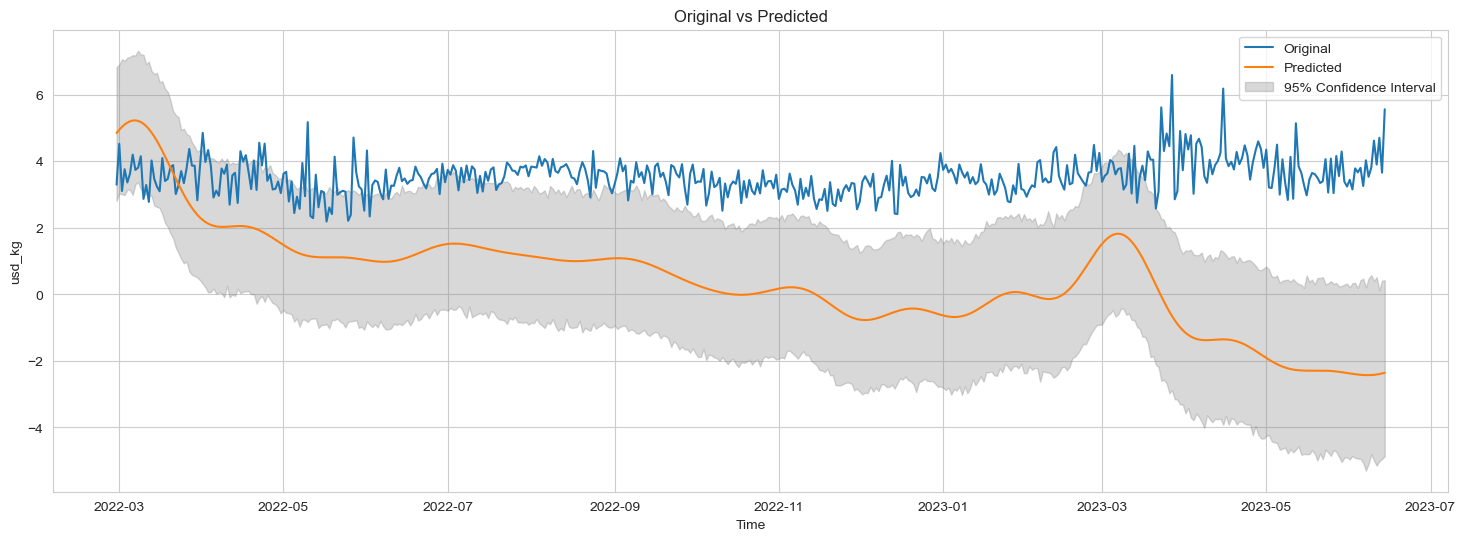

In [92]:
model = prophet_1.model(target_variable=y,
                        target_name=observations,
                        timepoints=data.index,
                        training_fraction=0.8)
print(model.test())
model.plot_test()

#### Prophet using extracted seasonal patterns


13:31:17 - cmdstanpy - INFO - Chain [1] start processing
13:31:18 - cmdstanpy - INFO - Chain [1] done processing


{'rmse': 3.313745514593121, 'mae': 2.9780466855139593}


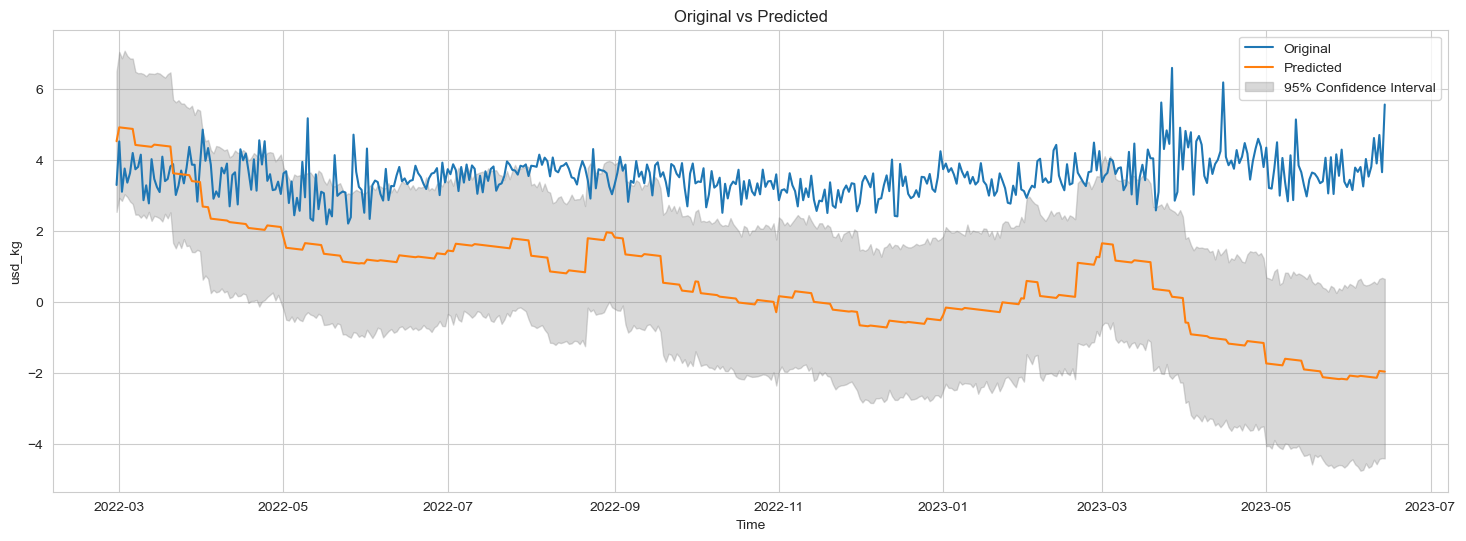

In [93]:
model = prophet_2.model(explanatory_variables = X,
                        target_variable=y,
                        target_name=observations,
                        timepoints=data.index,
                        training_fraction=0.8)
print(model.test())
model.plot_test()

#### Multi-step Prophet using extracted seasonal patterns and trend


13:31:18 - cmdstanpy - INFO - Chain [1] start processing
13:31:19 - cmdstanpy - INFO - Chain [1] done processing


{'rmse': 3.588973683569705, 'mae': 3.2540030618571283}


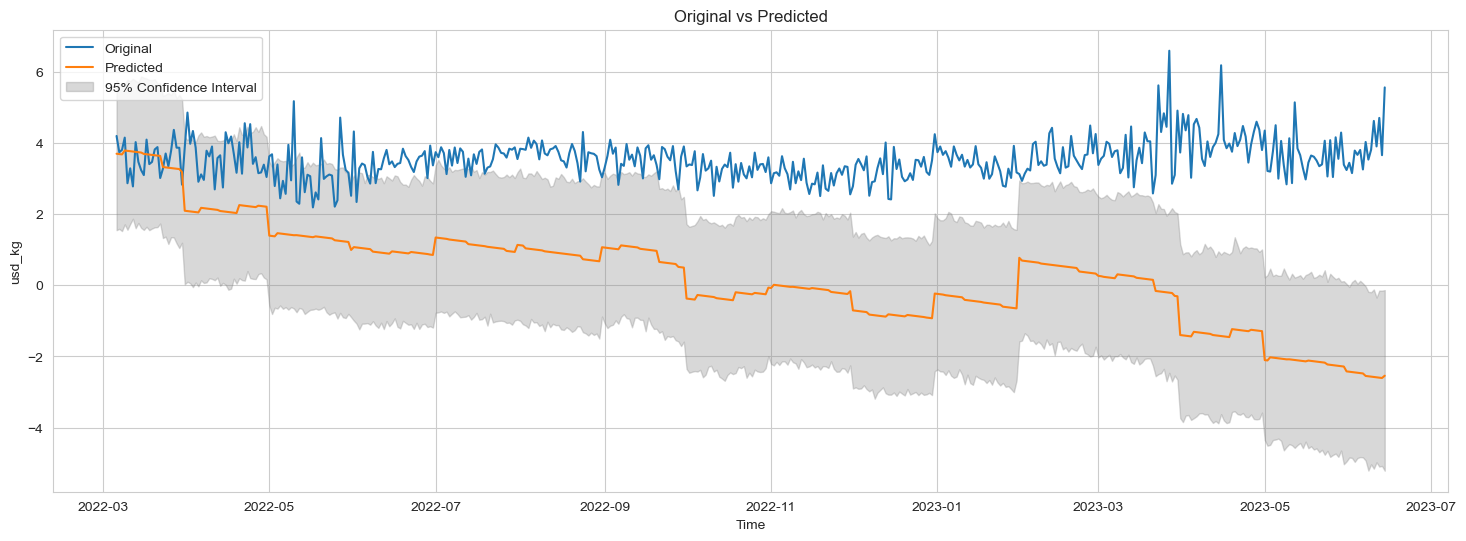

In [94]:
model = prophet_3.model(explanatory_variables = X,
                        target_variable=y,
                        target_name=observations,
                        timepoints=data.index,
                        training_fraction=0.8,
                        steps = 30)
print(model.test())
model.plot_test()

#### Multi-step ARIMAX

C:\Users\sergio\anaconda3\envs\thesis\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'rmse': 0.9137507731725456, 'mae': 0.7842028046335987}


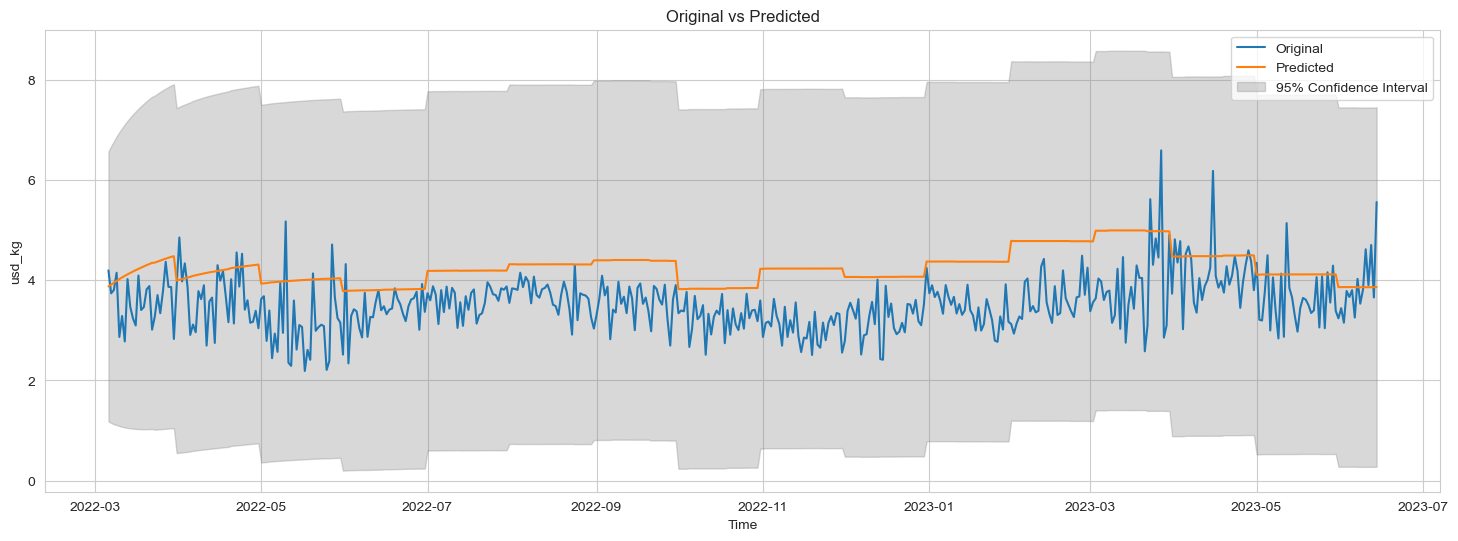

In [95]:
model = arima.model(explanatory_variables = X,
                        target_variable=y,
                        target_name=observations,
                        timepoints=data.index,
                        training_fraction=0.8,
                        steps = 30)
print(model.test())
model.plot_test()

In [96]:
# from statsmodels.tsa.arima.model import ARIMA
#
# # Create dataframe with the trend and seasonal patterns
# exog = pd.DataFrame(seasonal_patterns)
# exog['trend'] = trend
#
# # Get the train and test data
# train, test = data[observations].values[steps:train_size], data[observations].values[train_size:]
# train_exog, test_exog = exog[:train_size-steps], exog[train_size-steps:-steps]
#
# # Create model
# # fit model
# # model = ARIMA(train, order=(1,1,1), seasonal_order=(7,1,7,30))
# model = ARIMA(train, order=(1,0,1), exog=train_exog)
#
# # Fit model
# model = model.fit()
#
# # Make predictions
# forecast = model.get_prediction(start=train_size-steps, end=train_size-steps+len(test)-1, exog=test_exog)
#
# # Calculate error metrics
# mrse = np.sqrt(mean_squared_error(test, forecast.predicted_mean))
# mae = mean_absolute_error(test, forecast.predicted_mean)
# print("Mean Rooth Squared Error:", mrse)
# print("Mean Absolute Error:", mae)
#
#
# # Plot original vs predicted
# plt.figure(figsize=(18, 6))
# sns.lineplot(x = data.index[-len(test):], y=test, label='Original')
# sns.lineplot(x = data.index[-len(test):], y=forecast.predicted_mean, label='Predicted')
#
# plt.xlabel('Time')
# plt.ylabel(observations)
# plt.title('Original vs Predicted')
# plt.legend()
#
# plt.show()


#### Multi-step Gradient Boosting


{'rmse': 4.090033947343404, 'mae': 2.5834968976637622}


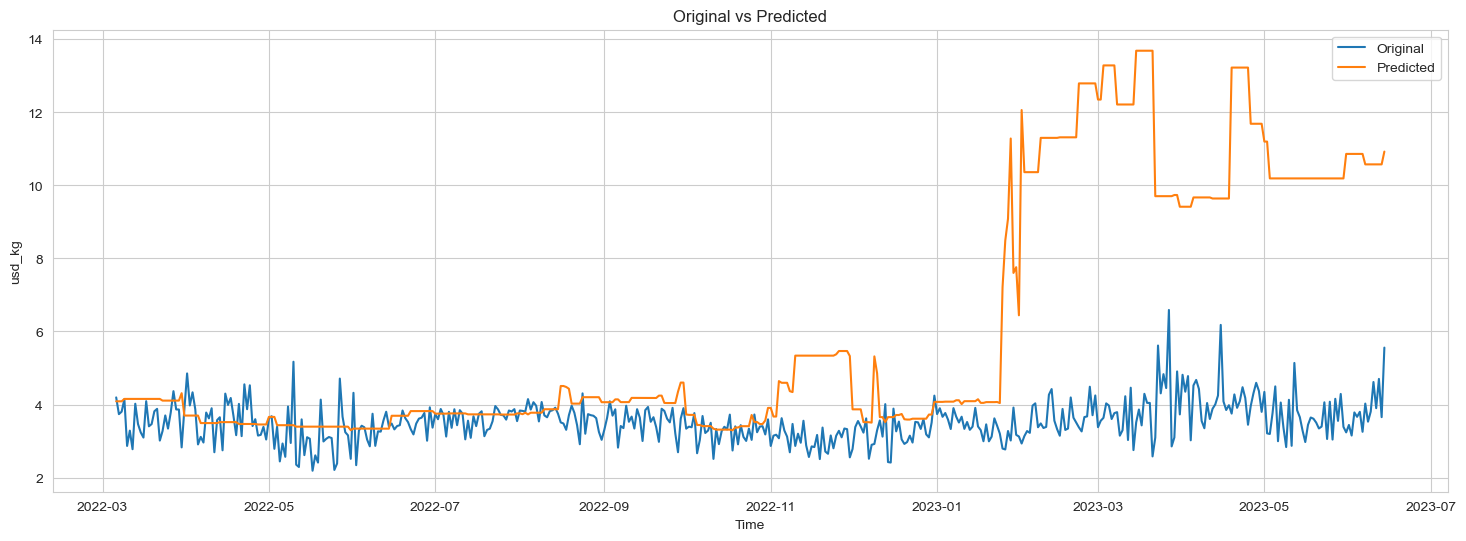

In [97]:
model = gradient_boosting.model(explanatory_variables = X,
                        target_variable=y,
                        target_name=observations,
                        timepoints=data.index,
                        training_fraction=0.8,
                        steps = 30)
print(model.test())
model.plot_test()

In [98]:
# from sklearn import ensemble
#
#
# params = {
#     "n_estimators": 2000,
#     "max_depth": 4,
#     "min_samples_split": 10,
#     "learning_rate": 0.01,
#     "loss": "squared_error",
# }
#
# # Create a model
# model = ensemble.GradientBoostingRegressor(**params)
# # Fit the model to the training data
# model.fit(X_train[:-steps], y_train[steps:])
#
# # Make predictions with the test data
# y_pred = model.predict(X_test[:-steps])
#
# # Calculate error metrics
# mrse = np.sqrt(mean_squared_error(y_test[steps:], y_pred))
# mae = mean_absolute_error(y_test[steps:], y_pred)
#
# print("Mean Rooth Squared Error:", mrse)
# print("Mean Absolute Error:", mae)
#
#
# # Plot original vs predicted
# plt.figure(figsize=(18, 6))
# sns.lineplot(x = data.index[-len(y_test[steps:]):], y=y_test[steps:], label='Original')
# sns.lineplot(x = data.index[-len(y_test[steps:]):], y=y_pred, label='Predicted')
# plt.xlabel('Time')
# plt.ylabel(observations)
# plt.title('Original vs Predicted')
# plt.legend()
#
# plt.show()
